# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットに対して特徴点を抽出するサンプルコードです。

In [4]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

In [5]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [6]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9287537,1196980


In [7]:
# 対象データ設定
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [8]:
# 最初のショットを取得して確認
dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,displacement,load01,load02,load03,load04,shot_number,tags
0,1.606752e+09,0,0,49.171,0.216,0.400,0.681,0.764,1,"[異常A, 異常B]"
1,1.606752e+09,1,1,49.245,0.209,0.400,0.711,0.772,1,"[異常A, 異常B]"
2,1.606752e+09,2,2,49.136,0.216,0.388,0.753,0.792,1,"[異常A, 異常B]"
3,1.606752e+09,3,3,49.184,0.228,0.382,0.774,0.792,1,"[異常A, 異常B]"
4,1.606752e+09,4,4,49.149,0.220,0.360,0.765,0.792,1,"[異常A, 異常B]"


In [9]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,80.598572,3125.0
1,2,80.613753,3113.0
2,3,80.594235,3129.0
3,4,80.636509,3097.0
4,5,80.582338,3140.0


In [10]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：2980


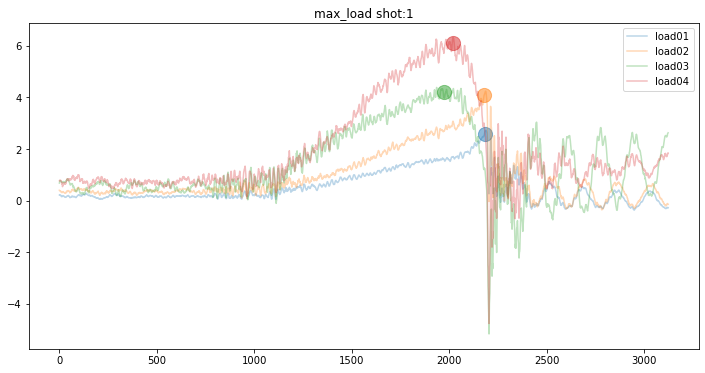

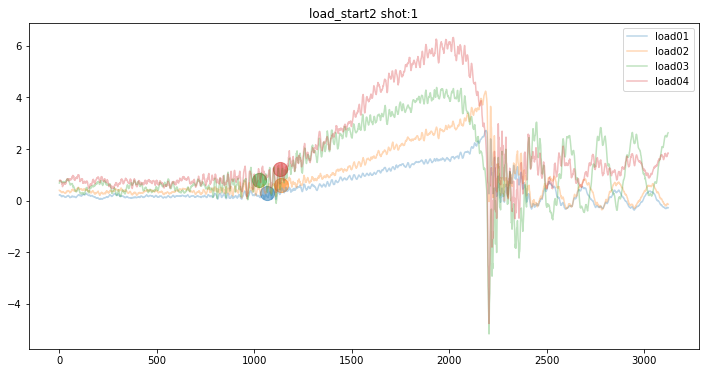

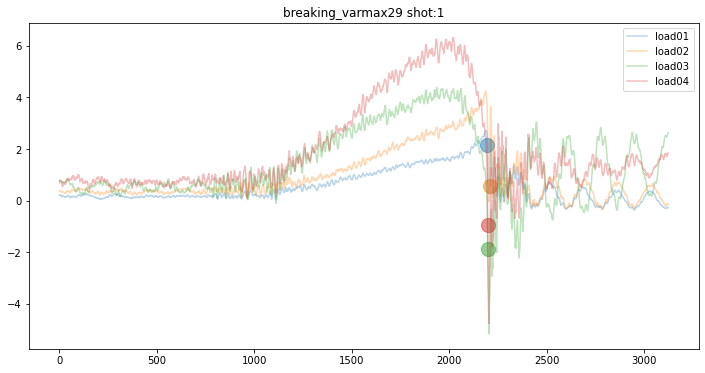

In [14]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values = extract_features(shot_df, 80.0, max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values =extract_features(shot_df, 80.0, load_start2, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values =extract_features(shot_df, 80.0, breaking_varmax29, shot=shot_number, disp_chart=True)

In [12]:
# 各特徴点のインデックス番号と値を確認
print(f"最大荷重点：{max_load_indicies}, {max_load_values}")
print(f"荷重開始点：{load_start_indicies}, {load_start_values}")
print(f"破断点　　：{break_load_indicies}, {break_load_values}")

最大荷重点：[2182, 2181, 1975, 2019], [2.578473352019181, 4.093000901090358, 4.2236528709983245, 6.099365441441266]
荷重開始点：[1064, 1136, 1026, 1133], [0.2827243107769417, 0.595899749373434, 0.7882556390977422, 1.2291729323308287]
破断点　　：[2197, 2208, 2198, 2198], [2.1449999999999965, 0.5699999999999886, -1.8599999999999883, -0.9559999999999856]


## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  
この処理には数分かかります。  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [13]:
apply(target="20201201010000")

2021-02-04 16:40:42,521 [INFO] delete index 'shots-20201201010000-max-point' finished. result: {'acknowledged': True}
2021-02-04 16:40:42,593 [INFO] delete index 'shots-20201201010000-start-point' finished. result: {'acknowledged': True}
2021-02-04 16:40:42,666 [INFO] delete index 'shots-20201201010000-break-point' finished. result: {'acknowledged': True}
2021-02-04 16:41:10,325 [INFO] process 5256: data read finished. shot_number: 2768 - 2980. data count: 663616
2021-02-04 16:41:25,701 [INFO] process 5254: data read finished. shot_number: 2342 - 2554. data count: 663615
2021-02-04 16:41:31,982 [INFO] process 5252: data read finished. shot_number: 1916 - 2128. data count: 663600
2021-02-04 16:41:43,261 [INFO] process 5250: data read finished. shot_number: 1490 - 1702. data count: 663604
2021-02-04 16:41:50,001 [INFO] process 5255: data read finished. shot_number: 2555 - 2767. data count: 663637
2021-02-04 16:41:51,310 [INFO] process 5246: data read finished. shot_number: 638 - 850. dat

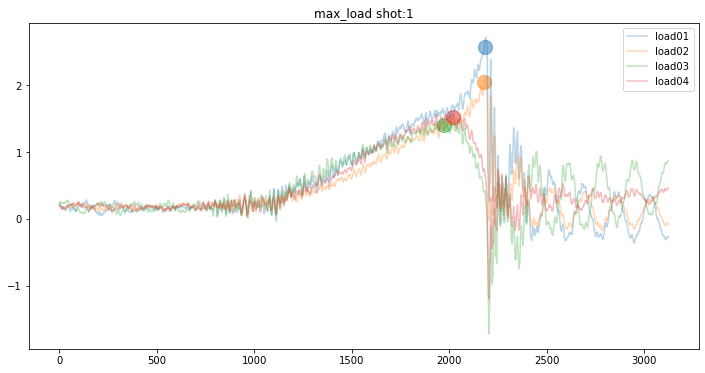

In [15]:
# temporary test
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)

max_load_indicies, max_load_values = extract_features(shot_df, 80.0, max_load, shot=shot_number, disp_chart=True)

In [16]:
print(f"最大荷重点：{max_load_indicies}, {max_load_values}")

最大荷重点：[2182, 2181, 1975, 2019], [2.578473352019181, 2.046500450545179, 1.4078842903327762, 1.5248413603603166]


In [17]:
shot_df[2181:2183]

,timestamp,sequential_number,sequential_number_by_shot,displacement,load01,load02,load03,load04,shot_number,tags
2181,1.606752e+09,2181,2181,39.2,2.561,2.060,0.421,0.720,1,"[異常A, 異常B]"
2182,1.606752e+09,2182,2182,39.2,2.612,2.064,0.417,0.701,1,"[異常A, 異常B]"
